## Introduction
The data used for this experiment is Canadian weather observations, compiled from weather stations across the country. As the data is quite large, a subset including only observations from the year 1917 has been chosen. The data includes positional and temporal information, as well as temperature, precipitation and snowfall measurements.
The model that was evaluated to be the best per Pycaret was the Random Forest Regressor, and this model is used here (technically Catboost performed the best across most metrics, but it's not in sci-kit learn, and Random Forest still had the best mean average error). This model fits a number of decision trees on subsets of the data, and takes averages to improve accuracy and reduce over-fitting.

### Data Definition
1. **Year**: Year of observation; only 1917 in this subset of the data (int64). Will be removed for this experiment as it is a constant value.
2. **Month**: Month of observation (int64).
3. **Stn_Name**: Name of station where observation was recorded (object).
4. **Prov**: Province in which the station is located (object).
5. **Lat**: Latitude coordinate of the station (float64).
6. **Long**: Longitude coordinate of the station (float64).
7. **Tm**: Recorded monthly average temperature (°C) (float64).
8. **S**: Recorded monthly average snowfall (cm) (float64).
9. **P**: Recorded monthly average precipitation (mm) (float64).

In [1]:
#import necessary libraries
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
 
from sklearn.metrics import mean_absolute_error, mean_squared_error,  r2_score, explained_variance_score
from MyFuns import adj_r2

In [2]:
#read in csv to df
df = pd.read_csv('./data/1917_full.csv', encoding='utf-16')
df.head()

,Year,Month,Stn_Name,Prov,Lat,Long,Tm,S,P
0,1917,1,ALIX,AB,52.383,-113.167,-15.400000,40.200001,42.000000
1,1917,1,ALLIANCE,AB,52.433,-111.783,-17.299999,0.000000,0.000000
2,1917,1,ATHABASCA LANDING,AB,54.717,-113.283,-20.700001,26.400000,26.400000
3,1917,1,BANFF,AB,51.183,-115.567,-11.400000,18.299999,18.299999
4,1917,1,BASHAW,AB,52.683,-112.867,0.000000,22.900000,35.599998


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5979 entries, 0 to 5978
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Year      5979 non-null   int64  
 1   Month     5979 non-null   int64  
 2   Stn_Name  5979 non-null   object 
 3   Prov      5979 non-null   object 
 4   Lat       5967 non-null   float64
 5   Long      5967 non-null   float64
 6   Tm        5979 non-null   float64
 7   S         5979 non-null   float64
 8   P         5979 non-null   float64
dtypes: float64(5), int64(2), object(2)
memory usage: 420.5+ KB


In [5]:
#choose our target - I went with snowfall since it's directly correlated with the month, temperature and location
X = df.drop(['S', 'Year'], axis=1)
y = df['S']

In [6]:
#convert object columns to numerical for regression
le = LabelEncoder()
X['Prov'] = le.fit_transform(X['Prov'])
X['Stn_Name'] = le.fit_transform(X['Stn_Name'])
X.head()

,Month,Stn_Name,Prov,Lat,Long,Tm,P
0,1,5,0,52.383,-113.167,-15.400000,42.000000
1,1,7,0,52.433,-111.783,-17.299999,0.000000
2,1,22,0,54.717,-113.283,-20.700001,26.400000
3,1,28,0,51.183,-115.567,-11.400000,18.299999
4,1,35,0,52.683,-112.867,0.000000,35.599998


In [7]:
#split the data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=41)

In [8]:
#fit the model to the training data
mdl = RandomForestRegressor()
mdl.fit(X_train,y_train)

RandomForestRegressor()

In [9]:
#predict on the test set
y_pred = mdl.predict(X_test)
y_pred[0:5]

array([26.78799996,  0.        , 15.62000007, 25.99900052, 44.19000044])

In [10]:
#check our metrics
yrange = np.max(y_test) - np.min(y_test)
mae = mean_absolute_error(y_pred, y_test)
print(f'An MAE of {mae:.3} means the avg prediction error is about {mae / yrange * 100:.3}% of the total range of y.')

An MAE of 4.39 means the avg prediction error is about 1.5% of the total range of y.


In [11]:
rmse = np.sqrt(mean_squared_error(y_pred, y_test))
print(f'An RMSE of {rmse:.3} means the avg prediction error is about {rmse / yrange * 100:.3}% of the total range of y.')

An RMSE of 11.3 means the avg prediction error is about 3.84% of the total range of y.


In [12]:
rsq = r2_score(y_pred, y_test)
print(f'An r-square score of {rsq:.5} means approx {rsq * 100:.3}% in the actual (y) values is explained by the predicted (y-pred) values.')

An r-square score of 0.77741 means approx 77.7% in the actual (y) values is explained by the predicted (y-pred) values.


In [13]:
ar2 = adj_r2(r2_score(y_pred, y_test), len(y), len(X.columns))
print(f'Similarly, an adjusted r-square score of {ar2:.5} means approx {ar2 * 100:.3}% in the actual (y) values is explained by the predicted (y-pred) values.')

Similarly, an adjusted r-square score of 0.77715 means approx 77.7% in the actual (y) values is explained by the predicted (y-pred) values.


In [14]:
#some more metrics and plotting
eval_df = pd.DataFrame({'Actuals':y_test, 'Preds':y_pred})
eval_df['diff'] = np.abs(eval_df['Actuals'] - eval_df['Preds'])
eval_df['residuals'] = eval_df['Actuals'] - eval_df['Preds']
eval_df.head()

,Actuals,Preds,diff,residuals
401,22.6,26.788000,4.188000,-4.188000
3743,0.0,0.000000,0.000000,0.000000
5218,0.8,15.620000,14.820000,-14.820000
5825,26.0,25.999001,0.000999,0.000999
179,10.1,44.190000,34.090000,-34.090000


In [15]:
eval_df.mean()

Actuals      14.521572
Preds        14.617299
diff          4.393162
residuals    -0.095727
dtype: float64

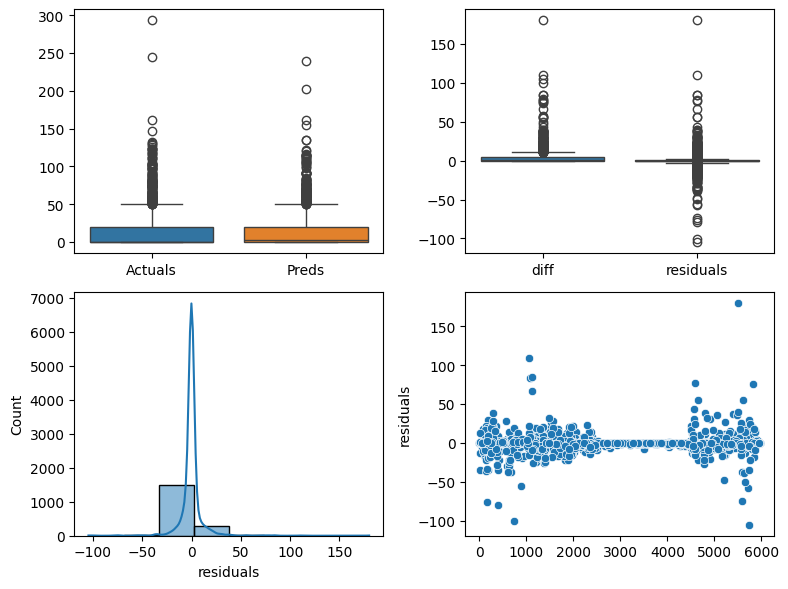

In [16]:
#we have most residuals very close to 0, but nonetheless have quite a few outliers
#the distribution of the residuals does not seem uniform/random so they are probably not independent
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8,6))
sns.boxplot(data=eval_df[['Actuals','Preds']], ax=axes[0,0])
sns.boxplot(data=eval_df[['diff','residuals']], ax=axes[0,1])
sns.histplot(data=eval_df['residuals'], kde=True, bins=8, ax=axes[1,0])
sns.scatterplot(data=eval_df['residuals'], ax=axes[1,1])

plt.tight_layout()
plt.show()

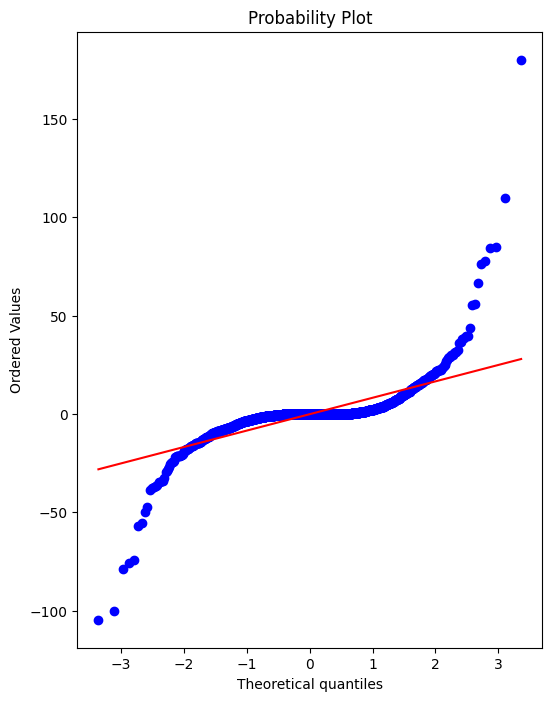

In [17]:
#we can see that the probability plot of the residuals indictes a cubic function
fig, ax = plt.subplots(figsize=(6,8))
_ = sp.stats.probplot(eval_df['residuals'], plot=ax)

plt.show()

## Summary
Based on our metrics, the RandomForestRegressor performed quite well. The average prediction errors are quite low and the r-score is near .8, showing that the model fits the data reasonably accurately and likely is not overfitting. The residuals are mostly uniformly distributed around zero.